
**Install requirements**

In [0]:
if(False):
  #!pip3 install 'torch==1.3.1'
  !pip3 install 'torch==1.4.0'
  !pip3 install 'torchvision==0.5.0'
  !pip3 install 'Pillow-SIMD'
  !pip3 install 'tqdm'


**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10
VAL_FREQUENCY = 2

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

In [5]:
#####     REMBER TO CHANGE caltech_dataset.py FILE INSIDE Caltech101 FOLDER                                   #####
#####     WITH THE CORRISPONDENT FILE INSIDE THE SUBMITTED ZIP FILE                                           #####
#####     IT MAY BE NEEDED ALSO TO RESTART THE KERNEL (RUNTIME -> RESTART RUNTIME) AND RUN AGAIN THE CELLS    #####
from Caltech101.caltech_dataset import Caltech
DATA_DIR = 'Caltech101/101_ObjectCategories'
def PrepareDataset():
  # Prepare Pytorch train/test Datasets
  train_dataset_Caltech = Caltech(DATA_DIR, split='train',  transform=train_transform)

  #Split ad-hoc inside Caltech class
  #train_indexes = []
  #val_indexes = []

  train_dataset = deepcopy(train_dataset_Caltech)
  train_dataset.SetTrain()

  val_dataset = train_dataset_Caltech
  val_dataset.SetVal()

  test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
  test_dataset.SetTest()


  # Check dataset sizes
  print('Train Dataset: {}'.format(len(train_dataset.samples_train)))
  print('Valid Dataset: {}'.format(len(val_dataset.samples_val)))
  print('Train/Valid Dataset Proportion: {} (Required: {})'.format( len(train_dataset.samples_train)/len(val_dataset.samples_val), int(1/1) ) )
  print('Test Dataset: {}'.format(len(test_dataset.samples)))

  return train_dataset, val_dataset, test_dataset
  
train_dataset, val_dataset, test_dataset = PrepareDataset()

Train Dataset: 2892
Valid Dataset: 2892
Train/Valid Dataset Proportion: 1.0 (Required: 1)
Test Dataset: 2893


CLASS DISTRIBUTION

In [0]:
#Remove/Change if statement to plot the class distribution 
if(False):
  classes_size = {}
  elements = 0
  targets = train_dataset.targets + val_dataset.targets + test_dataset.targets
  class_to_idx = train_dataset.class_to_idx 
  for i in targets:
    class_name = next((name for name, index in class_to_idx.items() if index == i), None)
    elements += 1
    if class_name not in classes_size:
      classes_size[class_name] = 0
    else:
      classes_size[class_name] = classes_size[class_name] + 1

  sorted_classes = dict(sorted(classes_size.items(), key=lambda x: x[1],reverse=True))
  fig, ax = plt.subplots(figsize=(20,10))
  x_pos = np.arange(len(train_dataset.classes))
  ax.set_xticks(x_pos)
  ax.set_xticklabels(list(sorted_classes.keys()),rotation='vertical', fontsize=13)

  plt.axhline(np.mean(list(classes_size.values())), c='r' )

  l , r = plt.xlim()
  value = 0.7
  plt.xlim( l-value, r+value )

  plt.bar(x_pos,sorted_classes.values())
  plt.title('Class Distribution')
  plt.xlabel('Class Name')
  plt.ylabel('# Occurrences')
  plt.show()

  print('Total Images: {}'.format(elements))
  print('Max # Images in a class: {}'.format(max(classes_size.values())))
  print('Min # Images in a class: {}'.format(min(classes_size.values())))
  print('Mean Images for classes: {:.3f}'.format(np.mean(list(classes_size.values()))))
  print('STD Images for classes: {:.3f}'.format(np.std(list(classes_size.values()))))

**Prepare Dataloaders**

In [0]:
def PrepareDataLoaders():
  # Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  return train_dataloader, val_dataloader, test_dataloader
train_dataloader, val_dataloader, test_dataloader = PrepareDataLoaders()

In [0]:
def NumParamsToTrain(net):
  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in net.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')
  diff = total_params-total_trainable_params
  print(f'{diff:,} frozen parameters.')
  ratio = total_trainable_params/total_params
  print(f'{ratio:.2f} ratio training/total.')

**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Validation**

In [0]:
def Validation(model, dataloader):
  model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  model.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in (dataloader):#tqdm
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = model(images)

    loss = criterion(outputs, labels)
    max = 6
    loss_value = loss.item() if loss.item()<max else max

    # Get predictions
    _, preds = torch.max(outputs.data, 1)
    
    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(dataloader.dataset))

  print('*** Validation Accuracy: {} ***'.format(accuracy))

  return (accuracy, loss_value)

**Train**

In [0]:
PATH_MODELS = 'Models/'
if not os.path.isdir('./'+PATH_MODELS):
  os.mkdir('./'+PATH_MODELS)
def Training(net, meta =''):
  # By default, everything is loaded to cpu
  model = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  current_epoch = 0
  loss_value = 0
  # Start iterating over the epochs

  #Test and Validation Loss and Accuracy
  train = []
  valid = []
  best_acc = -9999
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    running_corrects = 0
    # Iterate over the dataset
    for images, labels in train_dataloader:
      #net.train(True)
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = net(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)
      max = 6
      loss_value = loss.item() if loss.item()<max else max

      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format( current_step, loss_value ))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

    # Calculate Accuracy
    accuracy = running_corrects / float(len(train_dataset))

    #Store training values each epoch
    train.append( (accuracy, loss_value) )

    
    #Evaluate the model each epoch and store the values
    acc_val = 0
    loss_val = 0
    if current_epoch % VAL_FREQUENCY == 0:
      acc_val, loss_val = Validation(net,val_dataloader)
      valid.append( (acc_val , loss_val) )

      #Get model with best accuracy
      if(best_acc < acc_val):
        best_acc = acc_val
        torch.save(net, PATH_MODELS+meta+'.pth')

    current_epoch += 1

    # Step the scheduler
    scheduler.step()

  return train, valid, best_acc

In [0]:
NumParamsToTrain(net)

57,417,637 total parameters.
57,417,637 training parameters.
0 frozen parameters.
1.00 ratio training/total.


In [0]:
if(False):
  #Train from scratch
  meta = 'scratch'
  test, valid, best_acc = Training(net,meta)

  print()
  best_net_scratch = torch.load(PATH_MODELS+meta+'.pth')
  print('Best accuracy on Validation set {}'.format(best_acc))
  _ = Validation(best_net_scratch, val_dataloader)

Starting epoch 1/30, LR = [0.0001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.549326419830322
Step 10, Loss 4.5553741455078125
*** Validation Accuracy: 0.12275242047026279 ***
Starting epoch 2/30, LR = [0.0001]
Step 20, Loss 4.547428607940674
Starting epoch 3/30, LR = [0.0001]
Step 30, Loss 4.543521881103516
*** Validation Accuracy: 0.1334716459197787 ***
Starting epoch 4/30, LR = [0.0001]
Step 40, Loss 4.540533542633057
Starting epoch 5/30, LR = [0.0001]
Step 50, Loss 4.548117160797119
*** Validation Accuracy: 0.13934993084370678 ***
Starting epoch 6/30, LR = [0.0001]
Step 60, Loss 4.538472652435303
Starting epoch 7/30, LR = [0.0001]
Step 70, Loss 4.548652172088623
*** Validation Accuracy: 0.1479944674965422 ***
Starting epoch 8/30, LR = [0.0001]
Step 80, Loss 4.537397384643555
Starting epoch 9/30, LR = [0.0001]
Step 90, Loss 4.541634559631348
*** Validation Accuracy: 0.15352697095435686 ***
Starting epoch 10/30, LR = [0.0001]
Step 100, Loss 4.543827056884766
Starting epoch 11/30, LR = [1.0000000000000002e-06]
Step 110, Loss 4.538906097412109
Ste

In [0]:
def PlotAccuracyLoss(train, valid, meta=''):
  acc_train = np.array(train)[:,0]
  acc_valid = np.array(valid)[:,0]

  loss_train = np.array(train)[:,1]
  loss_valid = np.array(valid)[:,1]

  epoch_train = [i for i in range(len(acc_train))]
  epoch_val = [i*VAL_FREQUENCY for i in range(len(acc_valid))]

  fig, ax = plt.subplots(1,2,figsize=(13,7))
  size = 10

  color_train = '#ff0000'
  color_val = '#00ff00'

  ax[0].plot(epoch_train,loss_train,color=color_train)
  ax[0].scatter(epoch_train,loss_train,marker='s',s=size,color=color_train)
  ax[0].plot(epoch_val,loss_valid,color=color_val)
  ax[0].scatter(epoch_val,loss_valid,marker='s',s=size,color=color_val)
  ax[0].set_title('Loss Graph')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')

  ax[1].plot(epoch_train,acc_train,color=color_train)
  ax[1].scatter(epoch_train,acc_train,marker='s',s=size,color=color_train)
  ax[1].plot(epoch_val,acc_valid,color=color_val)
  ax[1].scatter(epoch_val,acc_valid,marker='s',s=size,color=color_val)
  ax[1].set_title('Accuracy Graph')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')

  fig.suptitle(meta)
  plt.legend(["Train", "Validation"])

  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

  print('Min Loss: Train: {:.6f}, Val: {:.6f}'.format( min(loss_train), min(loss_valid) ))
  print('Max Accuracy: Train: {:.6f}, Val: {:.6f}'.format( max(acc_train), max(acc_valid) ))

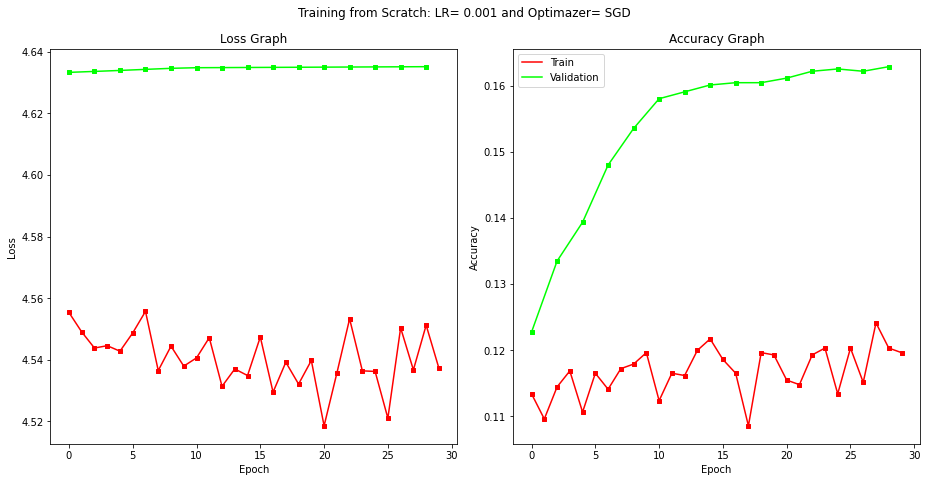

Min Loss: Train: 4.518587, Val: 4.633297
Max Accuracy: Train: 0.124136, Val: 0.162863


In [0]:
if(False):
  meta = 'Training from Scratch: LR= {} and Optimazer= SGD'.format(LR)
  PlotAccuracyLoss(test,valid, meta)

**Test**

In [0]:
if(False):
  #Old version
  '''
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataset))

  print('Test Accuracy: {}'.format(accuracy))
  '''
  #New version:
  result = Validation(best_net_scratch,test_dataloader)

*** Validation Accuracy: 0.1614241272035949 ***


Training using different parameters

In [0]:
  NUM_EPOCHS = 25
  lr_values = [0.01, 0.001, 0.00001]
  optimazers = ['Adam','RMSprop','SGD']

---  Training with LR = 0.01 and Optimazer = Adam  ---
Starting epoch 1/25, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.616472244262695
Step 10, Loss 6
*** Validation Accuracy: 0.005532503457814661 ***
Starting epoch 2/25, LR = [0.01]
Step 20, Loss 4.638514518737793
Starting epoch 3/25, LR = [0.01]
Step 30, Loss 4.605538368225098
*** Validation Accuracy: 0.023167358229598894 ***
Starting epoch 4/25, LR = [0.01]
Step 40, Loss 4.357470512390137
Starting epoch 5/25, LR = [0.01]
Step 50, Loss 4.251767635345459
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 6/25, LR = [0.01]
Step 60, Loss 4.178325176239014
Starting epoch 7/25, LR = [0.01]
Step 70, Loss 4.287017345428467
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 8/25, LR = [0.01]
Step 80, Loss 4.098994255065918
Starting epoch 9/25, LR = [0.01]
Step 90, Loss 4.239714622497559
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 10/25, LR = [0.01]
Step 100, Loss 4.282257556915283
Starting epoch 11/25, LR = [0.01]
Step 110, Loss 4.092345714569092
Step 120, Loss 4.288455486297607
*** Validation Accu

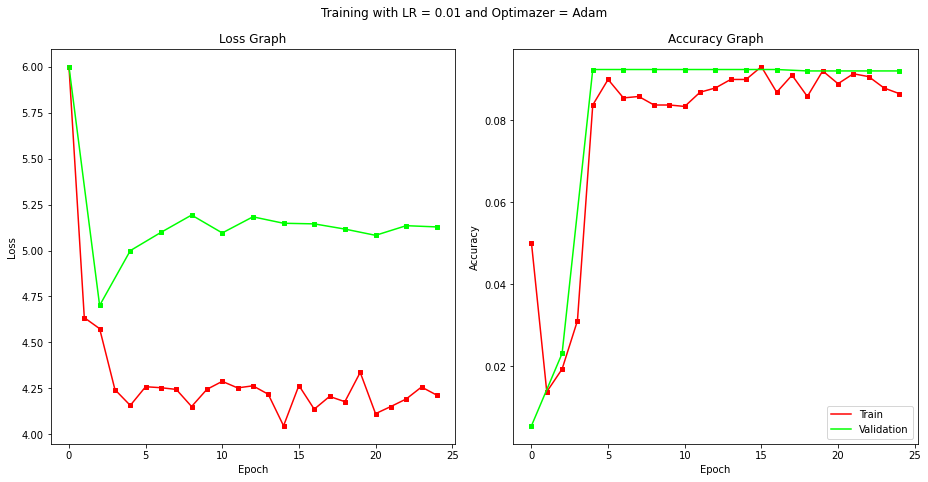

Min Loss: Train: 4.046507, Val: 4.701160
Max Accuracy: Train: 0.093015, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = RMSprop  ---
Starting epoch 1/25, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.612678527832031
Step 10, Loss 6
*** Validation Accuracy: 0.02731673582295989 ***
Starting epoch 2/25, LR = [0.01]
Step 20, Loss 6
Starting epoch 3/25, LR = [0.01]
Step 30, Loss 6
*** Validation Accuracy: 0.05013831258644537 ***
Starting epoch 4/25, LR = [0.01]
Step 40, Loss 6
Starting epoch 5/25, LR = [0.01]
Step 50, Loss 6
*** Validation Accuracy: 0.014868603042876901 ***
Starting epoch 6/25, LR = [0.01]
Step 60, Loss 5.5983195304870605
Starting epoch 7/25, LR = [0.01]
Step 70, Loss 6
*** Validation Accuracy: 0.05013831258644537 ***
Starting epoch 8/25, LR = [0.01]
Step 80, Loss 4.98038911819458
Starting epoch 9/25, LR = [0.01]
Step 90, Loss 4.7160162925720215
*** Validation Accuracy: 0.05013831258644537 ***
Starting epoch 10/25, LR = [0.01]
Step 100, Loss 4.492429733276367
Starting epoch 11/25, LR = [0.01]
Step 110, Loss 4.3640007972717285
Step 120, Loss 4.119126796722412
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 12/25, LR = [0.01]
Step 130, Loss 

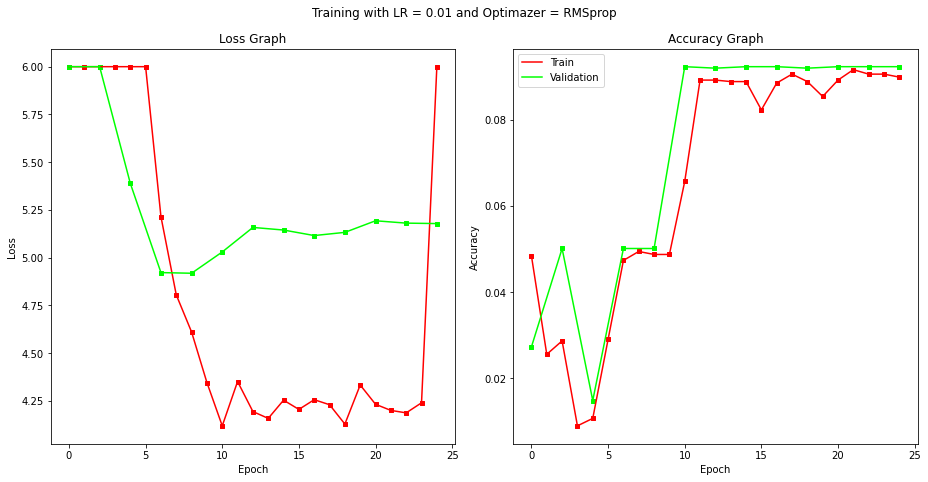

Min Loss: Train: 4.119127, Val: 4.918214
Max Accuracy: Train: 0.091632, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = SGD  ---
Starting epoch 1/25, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.61673641204834
Step 10, Loss 4.605294704437256
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 2/25, LR = [0.01]
Step 20, Loss 4.591428279876709
Starting epoch 3/25, LR = [0.01]
Step 30, Loss 4.547468662261963
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 4/25, LR = [0.01]
Step 40, Loss 4.4933247566223145
Starting epoch 5/25, LR = [0.01]
Step 50, Loss 4.294832229614258
*** Validation Accuracy: 0.14903181189488243 ***
Starting epoch 6/25, LR = [0.01]
Step 60, Loss 4.2797956466674805
Starting epoch 7/25, LR = [0.01]
Step 70, Loss 4.182689666748047
*** Validation Accuracy: 0.1545643153526971 ***
Starting epoch 8/25, LR = [0.01]
Step 80, Loss 4.174602508544922
Starting epoch 9/25, LR = [0.01]
Step 90, Loss 4.163902759552002
*** Validation Accuracy: 0.10546334716459198 ***
Starting epoch 10/25, LR = [0.01]
Step 100, Loss 4.129948616027832
Starting epoch 11/25, LR = [0.01]
Step 110, Loss 3.8003666400909424
Step 120, Loss 4.10096549987793
*** V

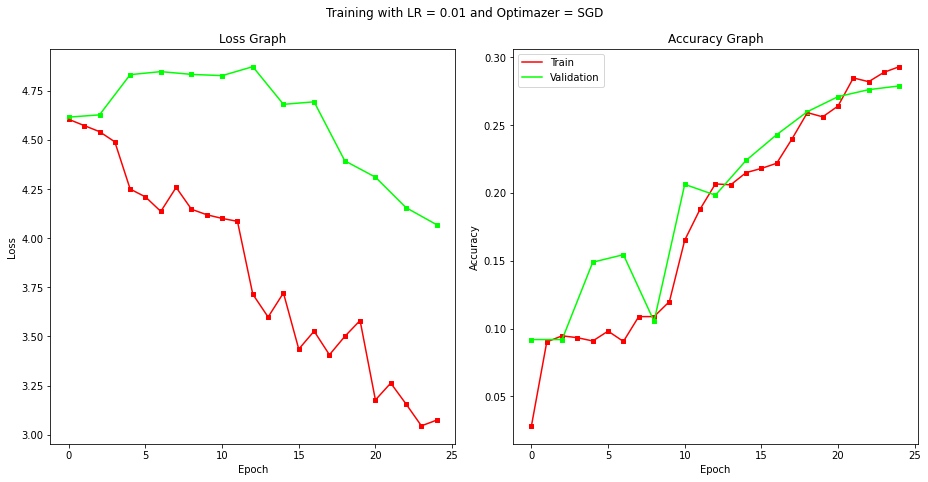

Min Loss: Train: 3.044732, Val: 4.068737
Max Accuracy: Train: 0.293223, Val: 0.279046
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = Adam  ---
Starting epoch 1/25, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.615053176879883
Step 10, Loss 4.499377727508545
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 2/25, LR = [0.001]
Step 20, Loss 4.345654487609863
Starting epoch 3/25, LR = [0.001]
Step 30, Loss 4.203819751739502
*** Validation Accuracy: 0.11583679114799447 ***
Starting epoch 4/25, LR = [0.001]
Step 40, Loss 4.073617935180664
Starting epoch 5/25, LR = [0.001]
Step 50, Loss 4.053163528442383
*** Validation Accuracy: 0.16977869986168742 ***
Starting epoch 6/25, LR = [0.001]
Step 60, Loss 3.8634955883026123
Starting epoch 7/25, LR = [0.001]
Step 70, Loss 3.5293684005737305
*** Validation Accuracy: 0.22994467496542184 ***
Starting epoch 8/25, LR = [0.001]
Step 80, Loss 3.5675246715545654
Starting epoch 9/25, LR = [0.001]
Step 90, Loss 3.2569968700408936
*** Validation Accuracy: 0.2676348547717842 ***
Starting epoch 10/25, LR = [0.001]
Step 100, Loss 3.128974199295044
Starting epoch 11/25, LR = [0.001]
Step 110, Loss 3.1827285289764404
Step 120, Loss 3.2030904

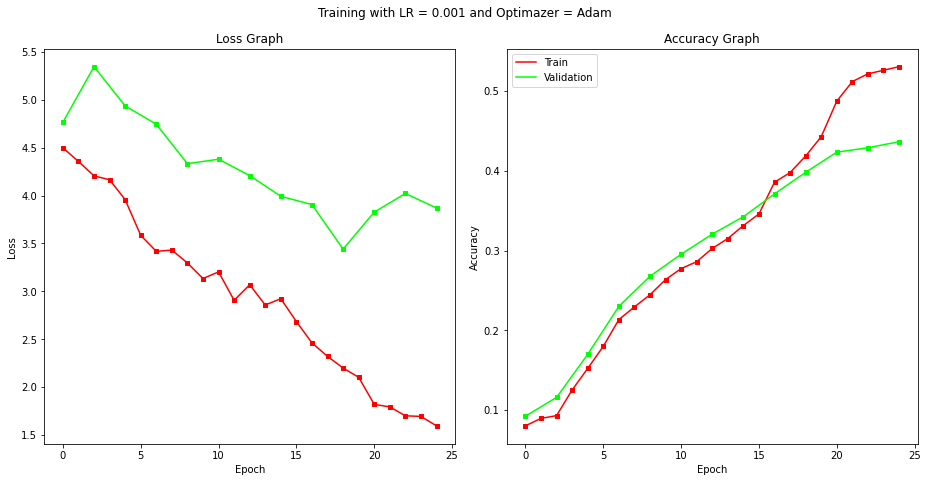

Min Loss: Train: 1.594674, Val: 3.441350
Max Accuracy: Train: 0.530429, Val: 0.436376
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = RMSprop  ---
Starting epoch 1/25, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.6166534423828125
Step 10, Loss 6
*** Validation Accuracy: 0.00656984785615491 ***
Starting epoch 2/25, LR = [0.001]
Step 20, Loss 6
Starting epoch 3/25, LR = [0.001]
Step 30, Loss 6
*** Validation Accuracy: 0.03734439834024896 ***
Starting epoch 4/25, LR = [0.001]
Step 40, Loss 6
Starting epoch 5/25, LR = [0.001]
Step 50, Loss 6
*** Validation Accuracy: 0.010027662517289074 ***
Starting epoch 6/25, LR = [0.001]
Step 60, Loss 6
Starting epoch 7/25, LR = [0.001]
Step 70, Loss 6
*** Validation Accuracy: 0.011065006915629323 ***
Starting epoch 8/25, LR = [0.001]
Step 80, Loss 4.654573917388916
Starting epoch 9/25, LR = [0.001]
Step 90, Loss 4.6194562911987305
*** Validation Accuracy: 0.011065006915629323 ***
Starting epoch 10/25, LR = [0.001]
Step 100, Loss 4.604207515716553
Starting epoch 11/25, LR = [0.001]
Step 110, Loss 4.5677103996276855
Step 120, Loss 4.53416109085083
*** Validation Accuracy: 0.02731673582295989 ***
Starting epoch 12/25, LR = [0.001]
Step 130, Loss 4.4

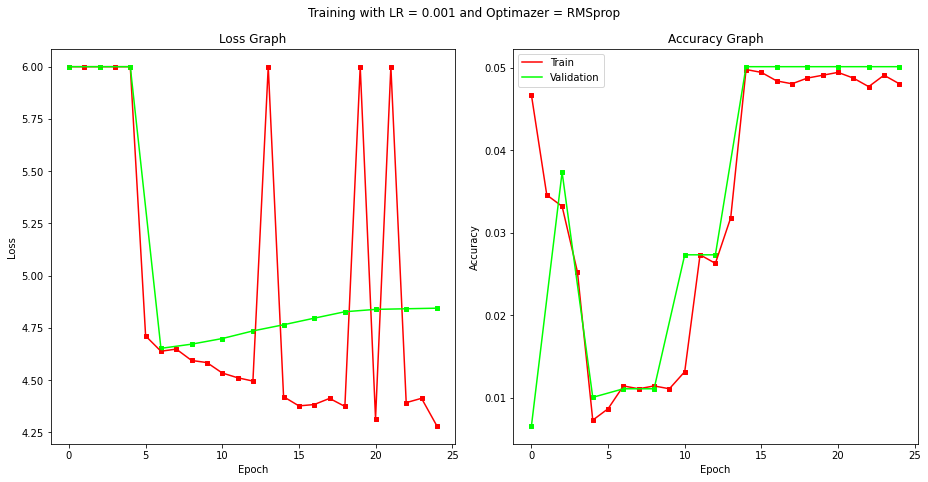

Min Loss: Train: 4.281332, Val: 4.652241
Max Accuracy: Train: 0.049793, Val: 0.050138
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = SGD  ---
Starting epoch 1/25, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.614181041717529
Step 10, Loss 4.613300800323486
*** Validation Accuracy: 0.006224066390041493 ***
Starting epoch 2/25, LR = [0.001]
Step 20, Loss 4.611794948577881
Starting epoch 3/25, LR = [0.001]
Step 30, Loss 4.609982013702393
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 4/25, LR = [0.001]
Step 40, Loss 4.6066765785217285
Starting epoch 5/25, LR = [0.001]
Step 50, Loss 4.602516174316406
*** Validation Accuracy: 0.09094052558782849 ***
Starting epoch 6/25, LR = [0.001]
Step 60, Loss 4.598806858062744
Starting epoch 7/25, LR = [0.001]
Step 70, Loss 4.600704193115234
*** Validation Accuracy: 0.08921161825726141 ***
Starting epoch 8/25, LR = [0.001]
Step 80, Loss 4.594597339630127
Starting epoch 9/25, LR = [0.001]
Step 90, Loss 4.592318058013916
*** Validation Accuracy: 0.07572614107883817 ***
Starting epoch 10/25, LR = [0.001]
Step 100, Loss 4.58709192276001
Starting epoch 11/25, LR = [0.001]
Step 110, Loss 4.586092948913574
Step 120, Loss 4.5879001617

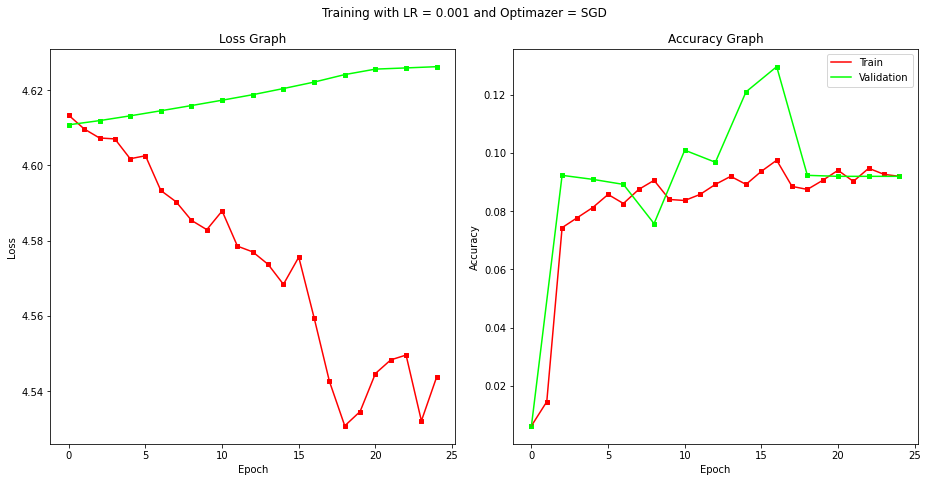

Min Loss: Train: 4.530813, Val: 4.610798
Max Accuracy: Train: 0.097510, Val: 0.129668
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = Adam  ---
Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.6135077476501465
Step 10, Loss 4.602420806884766
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 4.560542106628418
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 4.385259628295898
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 4.29435920715332
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 4.05391788482666
*** Validation Accuracy: 0.15214384508990317 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 4.219478607177734
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 4.28804874420166
*** Validation Accuracy: 0.09336099585062241 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 4.108649253845215
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 4.038994789123535
*** Validation Accuracy: 0.15387275242047027 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 4.102143287658691
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 4.1178388595581055
Step 120, Loss 4.179128646850

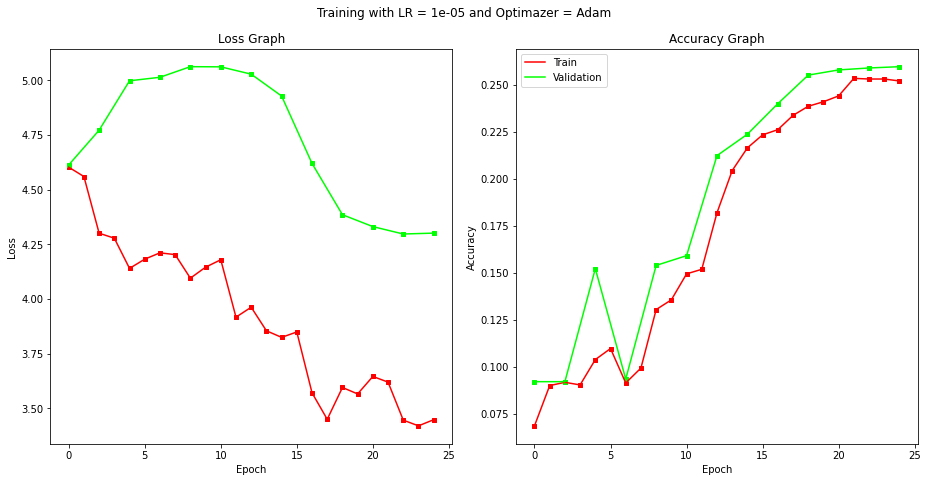

Min Loss: Train: 3.419765, Val: 4.296841
Max Accuracy: Train: 0.253458, Val: 0.259682
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = RMSprop  ---
Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.6150126457214355
Step 10, Loss 4.496932506561279
*** Validation Accuracy: 0.02731673582295989 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 4.335052490234375
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 4.352171421051025
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 4.265948295593262
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 4.302661895751953
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 4.217953681945801
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 4.223814010620117
*** Validation Accuracy: 0.12275242047026279 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 4.1934309005737305
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 4.119905471801758
*** Validation Accuracy: 0.19017980636237897 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 3.9217002391815186
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 3.6243579387664795
Step 120, Loss 3.5453920

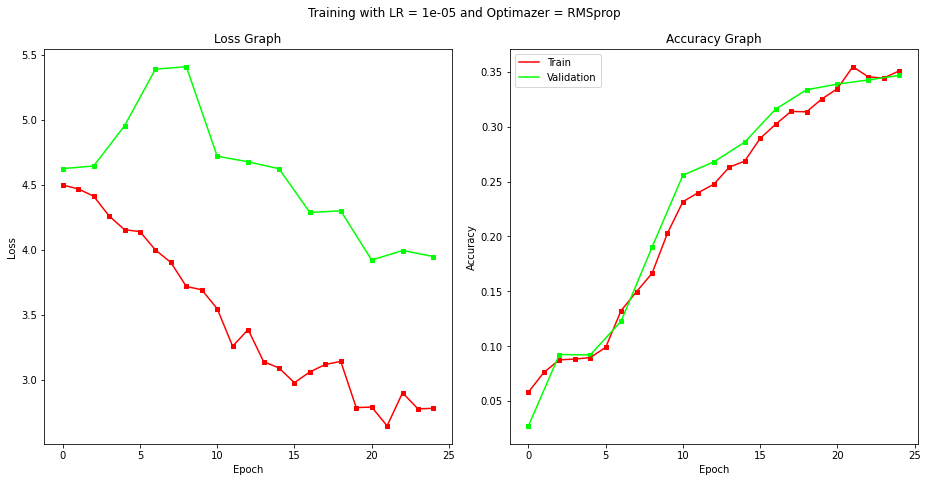

Min Loss: Train: 2.644383, Val: 3.919660
Max Accuracy: Train: 0.354772, Val: 0.346819
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = SGD  ---
Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.613007068634033
Step 10, Loss 4.612163066864014
*** Validation Accuracy: 0.005878284923928077 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 4.613016605377197
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 4.611605167388916
*** Validation Accuracy: 0.00656984785615491 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 4.61215353012085
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 4.612150192260742
*** Validation Accuracy: 0.00656984785615491 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 4.6121907234191895
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 4.611086845397949
*** Validation Accuracy: 0.00656984785615491 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 4.612879753112793
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 4.6118035316467285
*** Validation Accuracy: 0.00656984785615491 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 4.612321376800537
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 4.611510753631592
Step 120, Loss 4.612694263

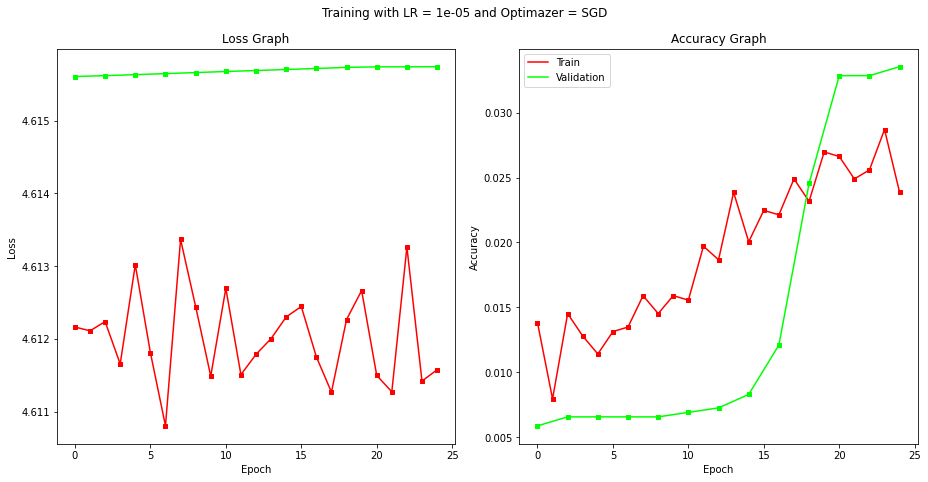

Min Loss: Train: 4.610805, Val: 4.615606
Max Accuracy: Train: 0.028700, Val: 0.033541
---  --- ---  ---



In [0]:
if(False):
  
  scores_scratch = {}
  for lr in lr_values:
    for op in optimazers:

      meta = 'Training with LR = {} and Optimazer = {}'.format(lr,op)
      print('---  {}  ---'.format(meta))

      net_scratch = alexnet()
      net_scratch.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
      criterion = nn.CrossEntropyLoss()

      parameters_to_optimize = net_scratch.parameters()
      if(op == 'Adam'):
        optimizer = optim.Adam(parameters_to_optimize, lr=lr, weight_decay=WEIGHT_DECAY)
      elif(op == 'RMSprop'):
        optimizer = optim.RMSprop(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      else:
        optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

      meta_t = 'scratch_'+str(lr)+'_'+op
      test, valid, best_acc = Training(net_scratch,meta_t)
      PlotAccuracyLoss(test,valid,meta=meta)

      best_net = torch.load(PATH_MODELS+meta_t+'.pth')
      scores_scratch[(lr,op)] = (test,valid, best_acc)

      print('---  --- ---  ---')
      print()


In [0]:
def GetMaxAcc(scores,printAll=False):
  values = dict()
  for k,v in scores.items():
    if(printAll):
      print(k)

    count = 0
    values[k] = []
    train = (0,0)
    val = (0,0)
    for i in v:
      if(count==0):
        train = ( np.min(np.array(i)[:,1]), np.max(np.array(i)[:,0]) )
        if(printAll):
          #print('Train: Min Loss {}'.format(train[0]))
          print('Train: Max Acc {}'.format(train[1]))
      elif(count==1):
        val = ( np.min(np.array(i)[:,1]), np.max(np.array(i)[:,0]) )
        if(printAll):
          print('Val: Min Loss {}'.format(val[0]))
          print('Val: Max Acc {}'.format(val[1]))
      count += 1
    values[k].append(train)
    values[k].append(val)
    if(printAll):
      print('---  ----  ----')
  return values
  
def SketchHeatMap(scores,trainAcc=False):
  score = GetMaxAcc(scores)

  keys = list(score.keys())
  x = sorted(set(i[0] for i in keys),reverse=True)
  y = sorted(set(i[1] for i in keys))

  meta = ''
  if (trainAcc):
    index = 0
    meta = 'Training'
  else: 
    index = 1
    meta = 'Validation'

  values = []
  for v in list(score.values()):
    count = 0
    for i in v:
      if(count==index):
        values.append(i[1]) 
      count += 1

  v = np.reshape(values,(3,3))

  pd_scores = pd.DataFrame(v, index=x, columns=y)
  sns.heatmap(pd_scores, vmin=0, vmax=1, linewidths=.1, annot=True,xticklabels='auto', yticklabels='auto')
  plt.xlabel("Optimizer")
  plt.ylabel("Learning Rate")
  plt.title('HeatMap {} Accuracy'.format(meta))
  plt.show()

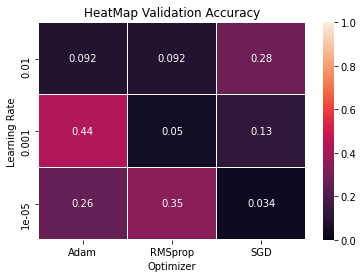

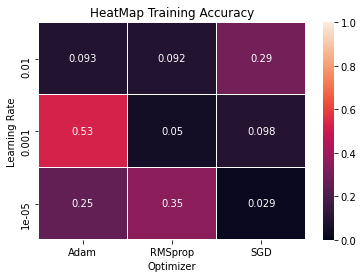

In [0]:
if(False):
  SketchHeatMap(scores_scratch)
  SketchHeatMap(scores_scratch,True)

In [0]:
if(False):
  lr_best = 0.001
  op_best = 'Adam'
  meta_t = str(lr_best)+'_'+op_best
  best_net_scratch = torch.load(PATH_MODELS+meta_t+'.pth')
  print('Best accuracy on Validation set {}'.format(scores_scratch[lr_best,op_best][2]))
  _ = Validation(best_net_scratch, val_dataloader)

Pre-Trainined net

In [0]:
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

train_dataset, val_dataset, test_dataset = PrepareDataset()

Train Dataset: 2892
Valid Dataset: 2892
Train/Valid Dataset Proportion: 1.0 (Required: 1)
Test Dataset: 2893


---  Training with LR = 0.01 and Optimazer = Adam  ---


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.9576640129089355
Step 10, Loss 6
*** Validation Accuracy: 0.0912863070539419 ***
Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.259235382080078
Starting epoch 3/30, LR = [0.01]
Step 30, Loss 6
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.3661789894104
Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.323718547821045
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 6/30, LR = [0.01]
Step 60, Loss 4.268521308898926
Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.3264312744140625
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 8/30, LR = [0.01]
Step 80, Loss 4.201079368591309
Starting epoch 9/30, LR = [0.01]
Step 90, Loss 4.298828601837158
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 10/30, LR = [0.01]
Step 100, Loss 4.260741233825684
Starting epoch 11/30, LR = [0.01]
Step 110, Loss 4.160210609436035
Step 120, Loss 4.180325508117676
*** Validation Accuracy: 0.09232365145

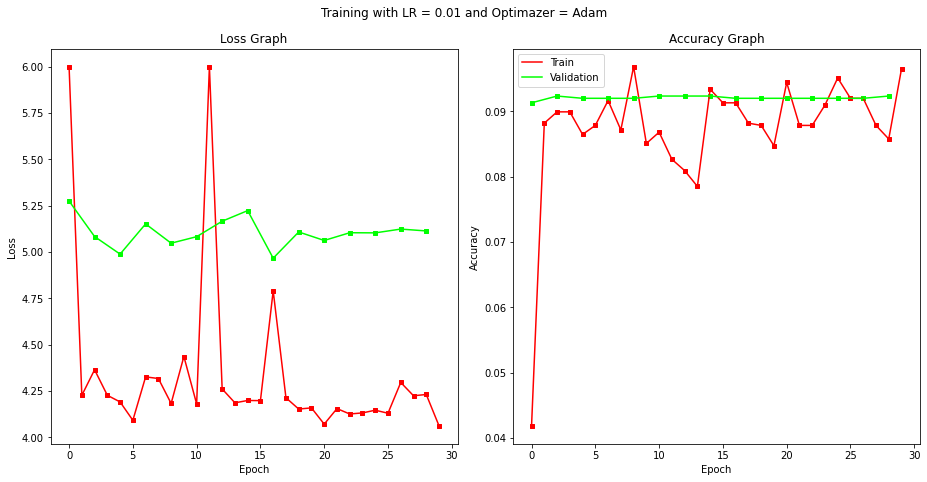

Min Loss: Train: 4.062088, Val: 4.966734
Max Accuracy: Train: 0.096819, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = RMSprop  ---
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.918703556060791
Step 10, Loss 6
*** Validation Accuracy: 0.006224066390041493 ***
Starting epoch 2/30, LR = [0.01]
Step 20, Loss 6
Starting epoch 3/30, LR = [0.01]
Step 30, Loss 6
*** Validation Accuracy: 0.00656984785615491 ***
Starting epoch 4/30, LR = [0.01]
Step 40, Loss 6
Starting epoch 5/30, LR = [0.01]
Step 50, Loss 6
*** Validation Accuracy: 0.05013831258644537 ***
Starting epoch 6/30, LR = [0.01]
Step 60, Loss 5.2907538414001465
Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.752191066741943
*** Validation Accuracy: 0.05013831258644537 ***
Starting epoch 8/30, LR = [0.01]
Step 80, Loss 6
Starting epoch 9/30, LR = [0.01]
Step 90, Loss 6
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 10/30, LR = [0.01]
Step 100, Loss 6
Starting epoch 11/30, LR = [0.01]
Step 110, Loss 6
Step 120, Loss 6
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 12/30, LR = [0.01]
Step 130, Loss 4.253011703491211
Starting epoch 13/30, LR = [0.01]
Step 140, Los

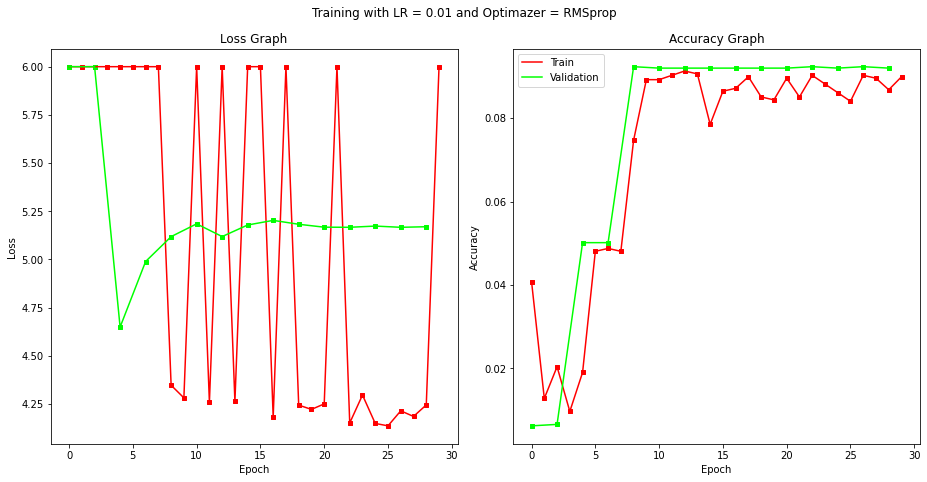

Min Loss: Train: 4.137217, Val: 4.649467
Max Accuracy: Train: 0.091286, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = SGD  ---
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.735172271728516
Step 10, Loss 2.25311279296875
*** Validation Accuracy: 0.5674273858921162 ***
Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.7699056267738342
Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.5510324835777283
*** Validation Accuracy: 0.8091286307053942 ***
Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.1953187733888626
Starting epoch 5/30, LR = [0.01]
Step 50, Loss 0.10430653393268585
*** Validation Accuracy: 0.8274550484094052 ***
Starting epoch 6/30, LR = [0.01]
Step 60, Loss 0.07820287346839905
Starting epoch 7/30, LR = [0.01]
Step 70, Loss 0.10438594967126846
*** Validation Accuracy: 0.8184647302904564 ***
Starting epoch 8/30, LR = [0.01]
Step 80, Loss 0.03838745877146721
Starting epoch 9/30, LR = [0.01]
Step 90, Loss 0.03664882481098175
*** Validation Accuracy: 0.8371369294605809 ***
Starting epoch 10/30, LR = [0.01]
Step 100, Loss 0.03476991131901741
Starting epoch 11/30, LR = [0.01]
Step 110, Loss 0.009118549525737762
Step 120, Loss 0.029994614

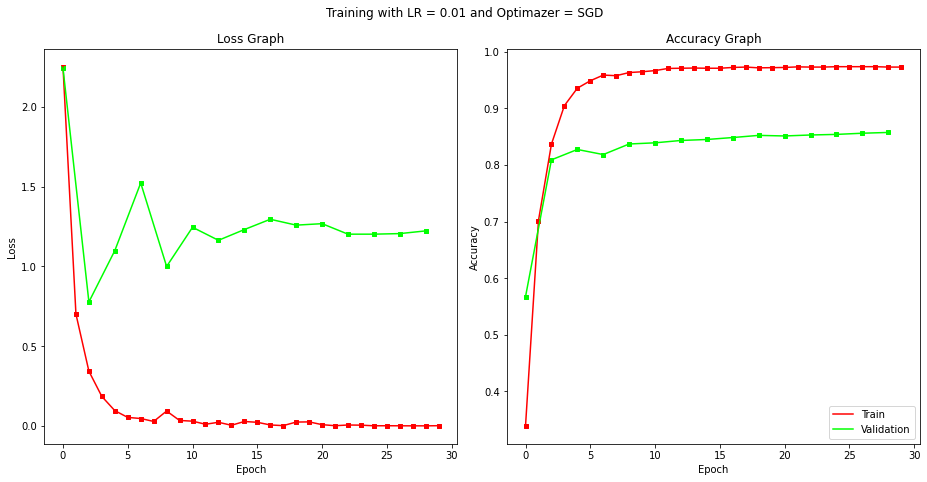

Min Loss: Train: 0.000686, Val: 0.777566
Max Accuracy: Train: 0.973721, Val: 0.857538
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = Adam  ---
Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.838233947753906
Step 10, Loss 4.432368755340576
*** Validation Accuracy: 0.1507607192254495 ***
Starting epoch 2/30, LR = [0.001]
Step 20, Loss 4.457128524780273
Starting epoch 3/30, LR = [0.001]
Step 30, Loss 4.097864151000977
*** Validation Accuracy: 0.14073305670816044 ***
Starting epoch 4/30, LR = [0.001]
Step 40, Loss 4.165122032165527
Starting epoch 5/30, LR = [0.001]
Step 50, Loss 3.9760358333587646
*** Validation Accuracy: 0.17946058091286307 ***
Starting epoch 6/30, LR = [0.001]
Step 60, Loss 3.8606796264648438
Starting epoch 7/30, LR = [0.001]
Step 70, Loss 3.8021371364593506
*** Validation Accuracy: 0.2008990318118949 ***
Starting epoch 8/30, LR = [0.001]
Step 80, Loss 3.643599033355713
Starting epoch 9/30, LR = [0.001]
Step 90, Loss 3.397319793701172
*** Validation Accuracy: 0.2652143845089903 ***
Starting epoch 10/30, LR = [0.001]
Step 100, Loss 3.283918619155884
Starting epoch 11/30, LR = [0.001]
Step 110, Loss 3.03279185295105
Step 120, Loss 3.002004146575

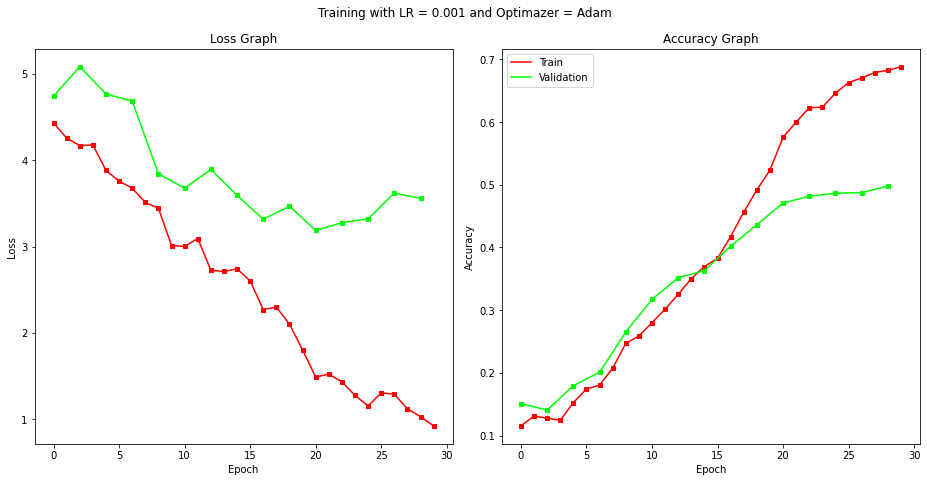

Min Loss: Train: 0.923827, Val: 3.188944
Max Accuracy: Train: 0.688451, Val: 0.497925
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = RMSprop  ---
Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.7975335121154785
Step 10, Loss 6
*** Validation Accuracy: 0.02074688796680498 ***
Starting epoch 2/30, LR = [0.001]
Step 20, Loss 6
Starting epoch 3/30, LR = [0.001]
Step 30, Loss 6
*** Validation Accuracy: 0.007607192254495159 ***
Starting epoch 4/30, LR = [0.001]
Step 40, Loss 6
Starting epoch 5/30, LR = [0.001]
Step 50, Loss 6
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 6/30, LR = [0.001]
Step 60, Loss 6
Starting epoch 7/30, LR = [0.001]
Step 70, Loss 6
*** Validation Accuracy: 0.00656984785615491 ***
Starting epoch 8/30, LR = [0.001]
Step 80, Loss 6
Starting epoch 9/30, LR = [0.001]
Step 90, Loss 6
*** Validation Accuracy: 0.05013831258644537 ***
Starting epoch 10/30, LR = [0.001]
Step 100, Loss 5.560683250427246
Starting epoch 11/30, LR = [0.001]
Step 110, Loss 6
Step 120, Loss 6
*** Validation Accuracy: 0.05013831258644537 ***
Starting epoch 12/30, LR = [0.001]
Step 130, Loss 6
Starting epoch 13/30, LR = [0.001]
Step 140, Loss 6
*** Validation A

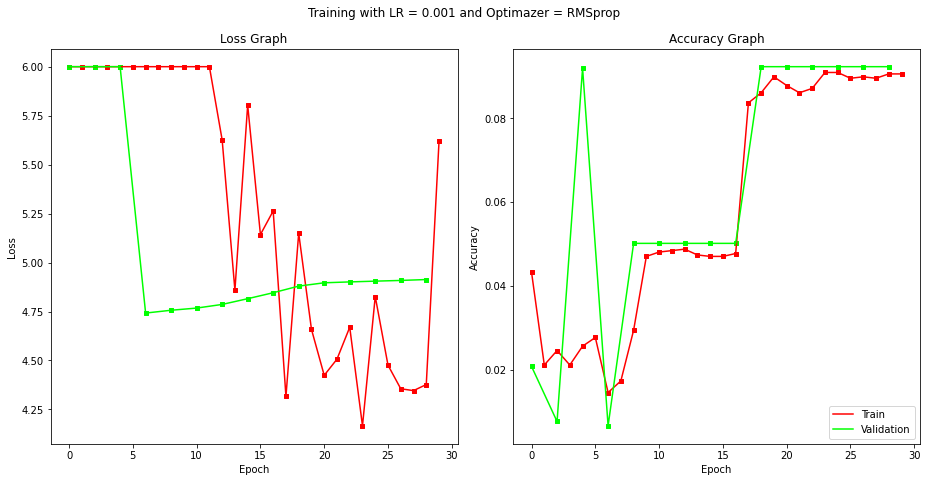

Min Loss: Train: 4.166353, Val: 4.742128
Max Accuracy: Train: 0.090941, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = SGD  ---
Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.876011371612549
Step 10, Loss 3.358396053314209
*** Validation Accuracy: 0.2672890733056708 ***
Starting epoch 2/30, LR = [0.001]
Step 20, Loss 2.551361322402954
Starting epoch 3/30, LR = [0.001]
Step 30, Loss 2.153614044189453
*** Validation Accuracy: 0.5646611341632088 ***
Starting epoch 4/30, LR = [0.001]
Step 40, Loss 1.294256329536438
Starting epoch 5/30, LR = [0.001]
Step 50, Loss 0.9715281128883362
*** Validation Accuracy: 0.7403181189488244 ***
Starting epoch 6/30, LR = [0.001]
Step 60, Loss 0.6975748538970947
Starting epoch 7/30, LR = [0.001]
Step 70, Loss 0.5462703108787537
*** Validation Accuracy: 0.7863070539419087 ***
Starting epoch 8/30, LR = [0.001]
Step 80, Loss 0.405947744846344
Starting epoch 9/30, LR = [0.001]
Step 90, Loss 0.2785702049732208
*** Validation Accuracy: 0.8022130013831259 ***
Starting epoch 10/30, LR = [0.001]
Step 100, Loss 0.23984743654727936
Starting epoch 11/30, LR = [0.001]
Step 110, Loss 0.15710291266441345
Step 120, Loss 0.20427721

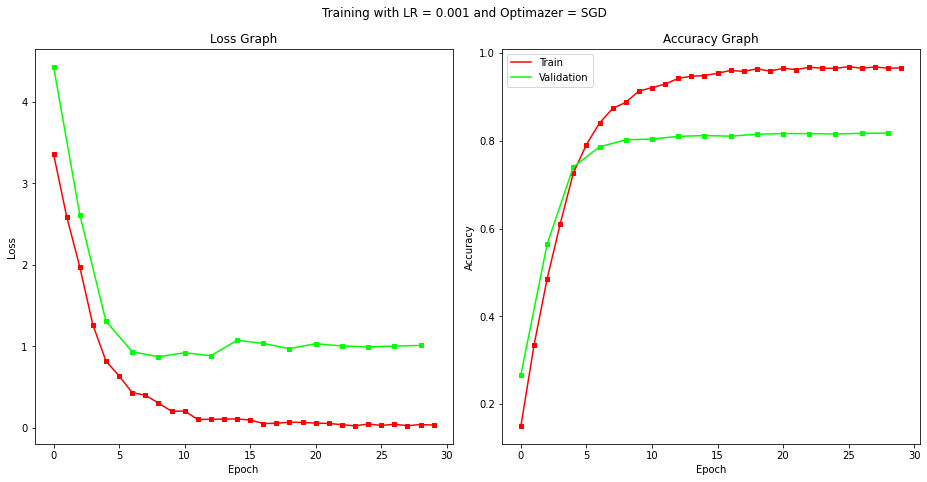

Min Loss: Train: 0.022669, Val: 0.869954
Max Accuracy: Train: 0.968880, Val: 0.817427
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = Adam  ---
Starting epoch 1/30, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.837611198425293
Step 10, Loss 4.342191219329834
*** Validation Accuracy: 0.17116182572614108 ***
Starting epoch 2/30, LR = [1e-05]
Step 20, Loss 3.705596923828125
Starting epoch 3/30, LR = [1e-05]
Step 30, Loss 3.4205315113067627
*** Validation Accuracy: 0.29771784232365145 ***
Starting epoch 4/30, LR = [1e-05]
Step 40, Loss 3.082569122314453
Starting epoch 5/30, LR = [1e-05]
Step 50, Loss 2.812485933303833
*** Validation Accuracy: 0.4315352697095436 ***
Starting epoch 6/30, LR = [1e-05]
Step 60, Loss 2.529085636138916
Starting epoch 7/30, LR = [1e-05]
Step 70, Loss 2.1987531185150146
*** Validation Accuracy: 0.5242047026279392 ***
Starting epoch 8/30, LR = [1e-05]
Step 80, Loss 1.754761815071106
Starting epoch 9/30, LR = [1e-05]
Step 90, Loss 1.7648985385894775
*** Validation Accuracy: 0.6113416320885201 ***
Starting epoch 10/30, LR = [1e-05]
Step 100, Loss 1.3333262205123901
Starting epoch 11/30, LR = [1e-05]
Step 110, Loss 1.144701361656189
Step 120, Loss 1.0848805904

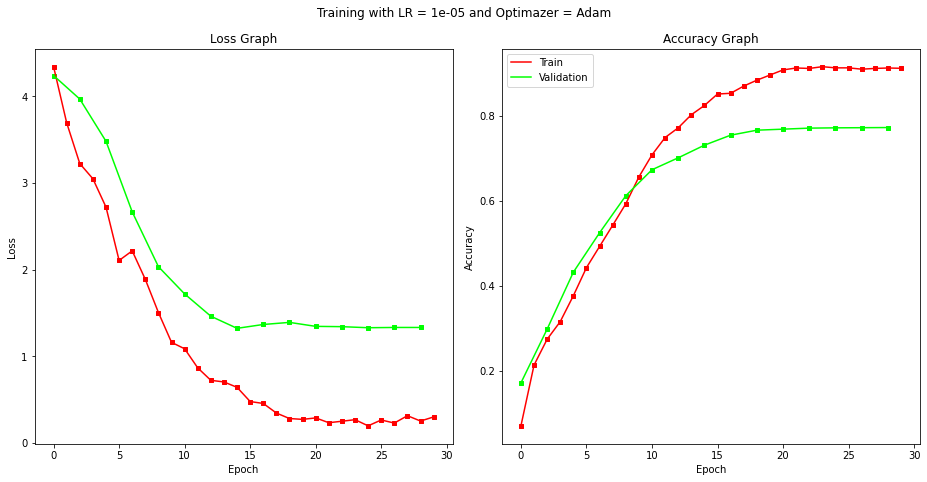

Min Loss: Train: 0.195330, Val: 1.321308
Max Accuracy: Train: 0.914938, Val: 0.771784
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = RMSprop  ---
Starting epoch 1/30, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.836855888366699
Step 10, Loss 2.2263596057891846
*** Validation Accuracy: 0.5674273858921162 ***
Starting epoch 2/30, LR = [1e-05]
Step 20, Loss 1.0296809673309326
Starting epoch 3/30, LR = [1e-05]
Step 30, Loss 0.34920260310173035
*** Validation Accuracy: 0.7869986168741355 ***
Starting epoch 4/30, LR = [1e-05]
Step 40, Loss 0.15571197867393494
Starting epoch 5/30, LR = [1e-05]
Step 50, Loss 0.12771008908748627
*** Validation Accuracy: 0.8367911479944675 ***
Starting epoch 6/30, LR = [1e-05]
Step 60, Loss 0.03516152501106262
Starting epoch 7/30, LR = [1e-05]
Step 70, Loss 0.05401737615466118
*** Validation Accuracy: 0.8437067773167358 ***
Starting epoch 8/30, LR = [1e-05]
Step 80, Loss 0.013969034887850285
Starting epoch 9/30, LR = [1e-05]
Step 90, Loss 0.010783708654344082
*** Validation Accuracy: 0.8482019363762102 ***
Starting epoch 10/30, LR = [1e-05]
Step 100, Loss 0.009183062240481377
Starting epoch 11/30, LR = [1e-05]
Step 110, Loss 0.015735186636447906
Step 120,

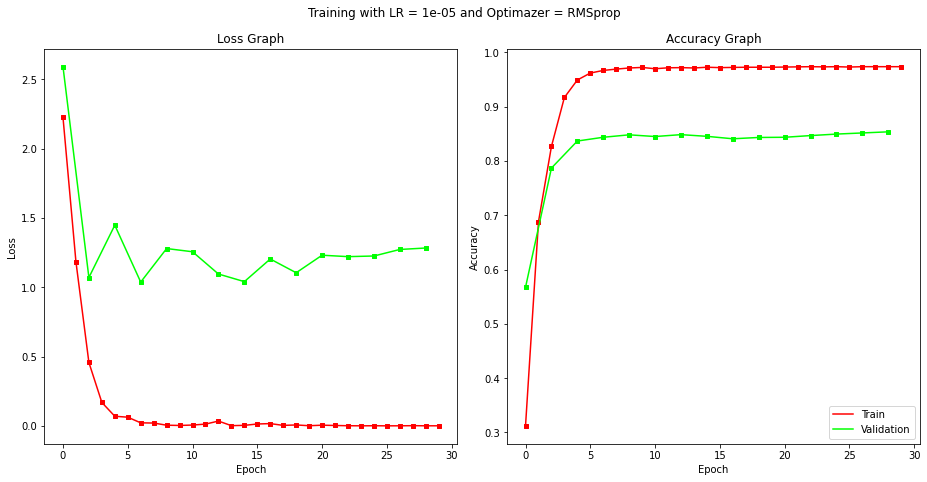

Min Loss: Train: 0.000438, Val: 1.037655
Max Accuracy: Train: 0.973721, Val: 0.853734
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = SGD  ---
Starting epoch 1/30, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.885808944702148
Step 10, Loss 4.8488688468933105
*** Validation Accuracy: 0.007261410788381743 ***
Starting epoch 2/30, LR = [1e-05]
Step 20, Loss 4.841338634490967
Starting epoch 3/30, LR = [1e-05]
Step 30, Loss 4.805697441101074
*** Validation Accuracy: 0.01037344398340249 ***
Starting epoch 4/30, LR = [1e-05]
Step 40, Loss 4.686885833740234
Starting epoch 5/30, LR = [1e-05]
Step 50, Loss 4.581295013427734
*** Validation Accuracy: 0.04322268326417704 ***
Starting epoch 6/30, LR = [1e-05]
Step 60, Loss 4.511463642120361
Starting epoch 7/30, LR = [1e-05]
Step 70, Loss 4.521815776824951
*** Validation Accuracy: 0.1103042876901798 ***
Starting epoch 8/30, LR = [1e-05]
Step 80, Loss 4.342060089111328
Starting epoch 9/30, LR = [1e-05]
Step 90, Loss 4.337545394897461
*** Validation Accuracy: 0.18810511756569848 ***
Starting epoch 10/30, LR = [1e-05]
Step 100, Loss 4.297398090362549
Starting epoch 11/30, LR = [1e-05]
Step 110, Loss 4.247303485870361
Step 120, Loss 4.2713780403

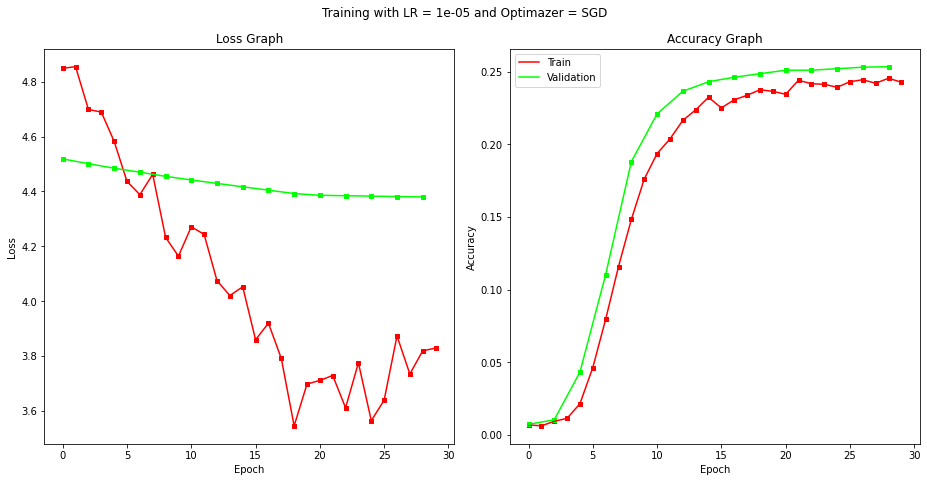

Min Loss: Train: 3.545728, Val: 4.380037
Max Accuracy: Train: 0.245505, Val: 0.253458
---  --- ---  ---



In [0]:
if(False):

  scores = {}
  for lr in lr_values:
    for op in optimazers:

      meta = 'Training with LR = {} and Optimazer = {}'.format(lr,op)
      print('---  {}  ---'.format(meta))

      net = alexnet(pretrained=True)
      net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
      criterion = nn.CrossEntropyLoss()

      parameters_to_optimize = net.parameters()
      if(op == 'Adam'):
        optimizer = optim.Adam(parameters_to_optimize, lr=lr, weight_decay=WEIGHT_DECAY)
      elif(op == 'RMSprop'):
        optimizer = optim.RMSprop(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      else:
        optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

      meta_t = 'pre_'+str(lr)+'_'+op
      test, valid, best_acc = Training(net,meta_t)
      PlotAccuracyLoss(test,valid,meta=meta)

      best_net = torch.load(PATH_MODELS+meta_t+'.pth')
      scores[(lr,op)] = (test,valid, best_acc)

      print('---  --- ---  ---')
      print()


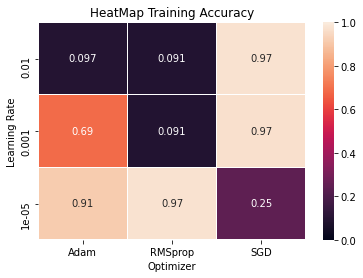

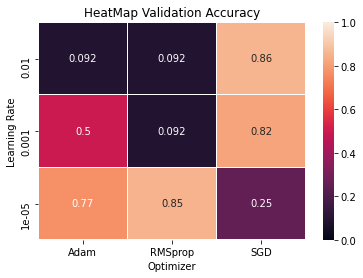

In [0]:
if(False):
  SketchHeatMap(scores,True)
  SketchHeatMap(scores)

In [0]:
#Update NUM_EPOCHS since RMSprop seems to converge before 15/20 epochs
NUM_EPOCHS = 25
best_lr = 0.00001
best_opti = 'RMSprop'

In [0]:
#Test the model on the test dataset using best parameters found
if(False):
  meta_t = 'pre_'+str(best_lr)+'_'+best_opti
  best_net = torch.load(PATH_MODELS+meta_t+'.pth')
  print('Best accuracy on Validation set {}'.format(scores[best_lr,best_opti][2]))
  _ = Validation(best_net, test_dataloader)

Best accuracy on Validation set 0.8537344398340249
*** Validation Accuracy: 0.8468717594192879 ***


Pre-Trainined net (Fixed CNN)

In [0]:
def FreezeNetwork(net, freeze=0):
  if(freeze!=0 and freeze!= 2):
    print('ERROR INPUT!! Received freeze = {} ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###'.format(freeze))
  else:
    #Set the training for all layers to False
    #freeze: 0 -> freeze FC, 2 -> freeze CNN
    count = 0
    for child in net.children():
      if(count==freeze):#count==freeze
        print('Freezing: {}. ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###'.format(freeze))
        for param in child.parameters():
              param.requires_grad = False
        exit
      count += 1
  #Print anyway the number of parameters
  NumParamsToTrain(net)
  return net

Freezing: 2. ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###
57,417,637 total parameters.
2,469,696 training parameters.
54,947,941 frozen parameters.
0.04 ratio training/total.

Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.869869232177734
Step 10, Loss 4.009583950042725
*** Validation Accuracy: 0.23098201936376211 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 3.7256228923797607
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 3.4601030349731445
*** Validation Accuracy: 0.2966804979253112 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 3.180682420730591
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 3.1195764541625977
*** Validation Accuracy: 0.3475103734439834 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 3.1507630348205566
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 2.838911771774292
*** Validation Accuracy: 0.3921161825726141 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 2.9198098182678223
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 2.6335883140563965
*** Validation Accuracy: 0.41770401106500693 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 2.3576691150665283
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 2.466918468475342
Step 120, Loss 2.6205065

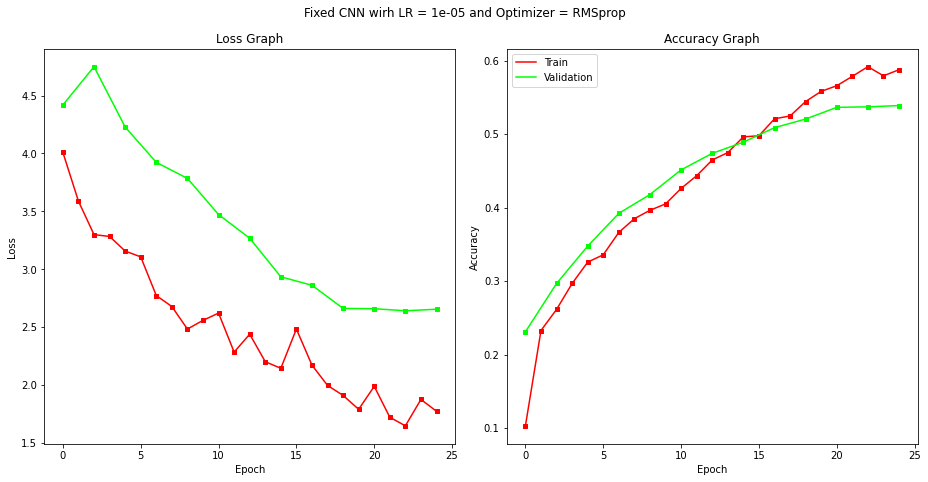

Min Loss: Train: 1.646055, Val: 2.640807
Max Accuracy: Train: 0.591632, Val: 0.538728
*** Validation Accuracy: 0.5278257863809195 ***


In [0]:
if(False):
  net = alexnet(pretrained=True)

  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

  net = FreezeNetwork(net,2)

  criterion = nn.CrossEntropyLoss()

  parameters_to_optimize = net.parameters()
  optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  print()
  meta_t = 'fixcnn_'+str(best_lr)+'_'+best_opti
  test, valid, best_acc = Training(net,meta_t)

  print()
  meta = 'Fixed CNN wirh LR = {} and Optimizer = {}'.format(best_lr, best_opti)
  PlotAccuracyLoss(test,valid,meta=meta)

  print()
  best_net = torch.load(PATH_MODELS+meta_t+'.pth')
  print('Best accuracy on Validation set {}'.format(best_acc))
  _ = Validation(best_net, test_dataloader)

Pre-Trainined net (Fixed FC Layer)

Freezing: 0. ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###
57,417,637 total parameters.
54,947,941 training parameters.
2,469,696 frozen parameters.
0.96 ratio training/total.

Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.878194332122803
Step 10, Loss 2.2130305767059326
*** Validation Accuracy: 0.6154910096818811 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 0.6986109614372253
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 0.3735431134700775
*** Validation Accuracy: 0.8070539419087137 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 0.1180286556482315
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 0.09660191833972931
*** Validation Accuracy: 0.8260719225449515 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 0.054223496466875076
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 0.032809894531965256
*** Validation Accuracy: 0.8450899031811895 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 0.029591692611575127
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 0.021769382059574127
*** Validation Accuracy: 0.8468188105117566 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 0.011352790519595146
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 0.03532698005437851
Step 120, 

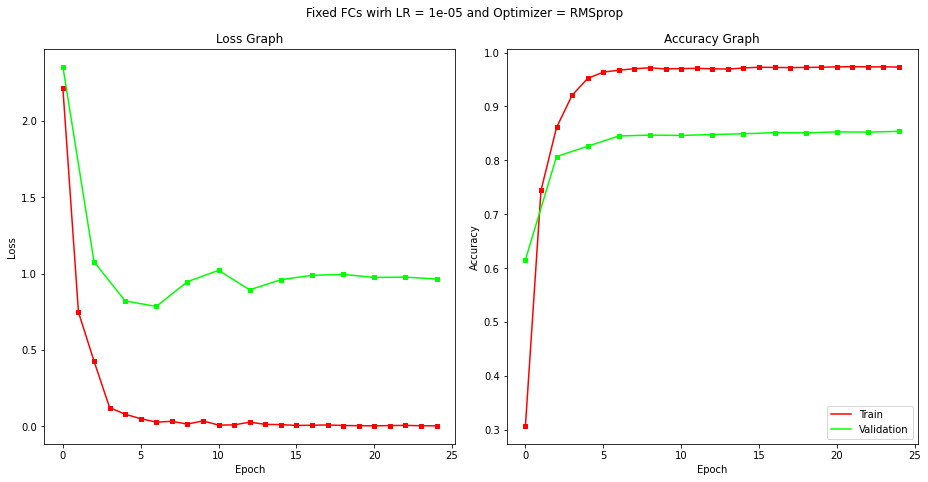

Min Loss: Train: 0.002025, Val: 0.784191
Max Accuracy: Train: 0.973721, Val: 0.853734

Best accuracy on Validation set 0.8537344398340249
*** Validation Accuracy: 0.8527480124438299 ***


In [0]:
if(False):
  net = alexnet(pretrained=True) # Loading AlexNet model

  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

  net = FreezeNetwork(net,0)

  criterion = nn.CrossEntropyLoss()

  parameters_to_optimize = net.parameters()
  optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  print()
  meta_t = 'fixfc_'+str(best_lr)+'_'+best_opti
  test, valid, best_acc = Training(net,meta_t)

  print()
  meta = 'Fixed FCs wirh LR = {} and Optimizer = {}'.format(best_lr, best_opti)
  PlotAccuracyLoss(test,valid,meta=meta)

  print()
  best_net = torch.load(PATH_MODELS+meta_t+'.pth')
  print('Best accuracy on Validation set {}'.format(best_acc))
  _ = Validation(best_net, test_dataloader)

Augmented Dataset

Train Dataset: 2892
Valid Dataset: 2892
Train/Valid Dataset Proportion: 1.0 (Required: 1)
Test Dataset: 2893

Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.641229152679443
Step 10, Loss 2.392103910446167
*** Validation Accuracy: 0.5529045643153527 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 0.7051266431808472
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 0.37766799330711365
*** Validation Accuracy: 0.8022130013831259 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 0.1719454675912857
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 0.07220719754695892
*** Validation Accuracy: 0.8208852005532503 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 0.04195854440331459
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 0.024875884875655174
*** Validation Accuracy: 0.8312586445366529 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 0.03795953094959259
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 0.010850537568330765
*** Validation Accuracy: 0.8322959889349931 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 0.06918953359127045
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 0.009926221333444118
Step 120, Lo

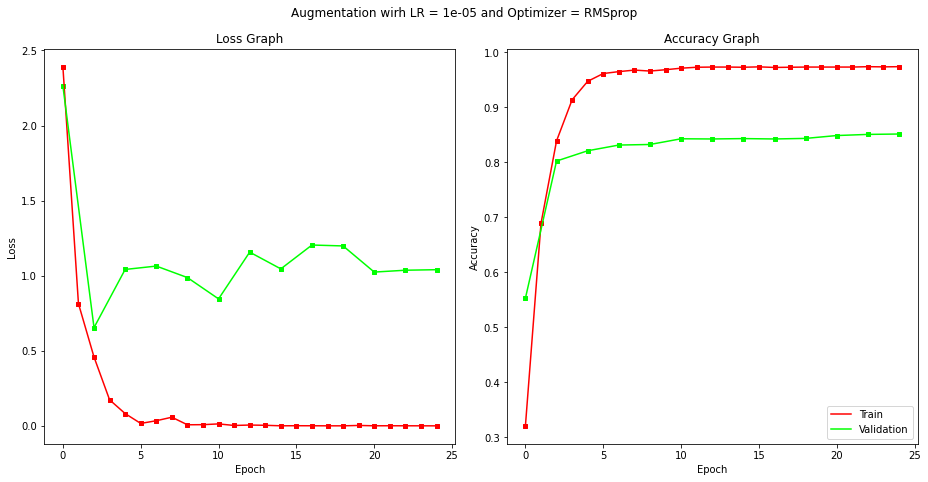

Min Loss: Train: 0.000796, Val: 0.654595
Max Accuracy: Train: 0.973721, Val: 0.851314

Best accuracy on Validation set 0.851313969571231
*** Validation Accuracy: 0.8482544071897684 ***


In [0]:
if(False):
  '''in any epoch the dataloader will apply a fresh set of random operations “on the fly”.
  So instead of showing the exact same items at every epoch,
  you are showing a variant that has been changed in a different way.
  So after three epochs, you would have seen three random variants of each item in a dataset.'''

  # Define transforms for training phase
  angle = 180
  p = 0.85
  transformations = [transforms.RandomHorizontalFlip(p=p), transforms.RandomRotation([-angle,angle]), transforms.RandomVerticalFlip(p=1-p), transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)]
  train_transform = transforms.Compose([transforms.RandomChoice(transformations),
                                        transforms.Resize(256),      
                                        transforms.CenterCrop(224),                         
                                                                    
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])
  # Define transforms for the evaluation phase
  eval_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
  ])

  PrepareDataset()

  net = alexnet(pretrained=True) # Loading AlexNet model

  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

  #net = FreezeNetwork(net,0)

  criterion = nn.CrossEntropyLoss()

  parameters_to_optimize = net.parameters()
  optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  print()
  meta = 'augm'+str(best_lr)+'_'+best_opti
  test, valid, best_acc = Training(net,meta_t)

  print()
  meta = 'Augmentation wirh LR = {} and Optimizer = {}'.format(best_lr, best_opti)
  PlotAccuracyLoss(test,valid,meta=meta)

  print()
  best_net = torch.load(PATH_MODELS+meta_t+'.pth')
  print('Best accuracy on Validation set {}'.format(best_acc))
  _ = Validation(best_net, test_dataloader)

Beyond AlexNet

In [14]:
train_transform = transforms.Compose([transforms.Resize(256),      
                                      transforms.CenterCrop(224),                         
                                                                   
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

train_dataset, val_dataset, test_dataset = PrepareDataset()

Train Dataset: 2892
Valid Dataset: 2892
Train/Valid Dataset Proportion: 1.0 (Required: 1)
Test Dataset: 2893


VGG16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



142,757,397 total parameters.
8,496,853 training parameters.
134,260,544 frozen parameters.
0.06 ratio training/total.

Starting epoch 1/25, LR = [0.000125]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.626198768615723
Step 10, Loss 4.57110071182251
Step 20, Loss 4.533763408660889
Step 30, Loss 4.568196773529053
Step 40, Loss 4.515344619750977
Step 50, Loss 4.507144927978516
Step 60, Loss 4.267587184906006
Step 70, Loss 4.427660942077637
Step 80, Loss 4.140195846557617
*** Validation Accuracy: 0.2074688796680498 ***
Starting epoch 2/25, LR = [0.000125]
Step 90, Loss 4.231388092041016
Step 100, Loss 4.246321678161621
Step 110, Loss 4.202450752258301
Step 120, Loss 4.003705024719238
Step 130, Loss 3.779813051223755
Step 140, Loss 3.8814783096313477
Step 150, Loss 3.815389633178711
Step 160, Loss 3.9167613983154297
Step 170, Loss 4.1053786277771
Starting epoch 3/25, LR = [0.000125]
Step 180, Loss 3.891995429992676
Step 190, Loss 3.6078851222991943
Step 200, Loss 4.073073387145996
Step 210, Loss 3.5949456691741943
Step 220, Loss 3.8854689598083496
Step 230, Loss 3.991511344909668
Step 240, Loss 3.65864896774292
Step 250, Loss 3.644702672958374
Step 260, Loss 3.7802197933197

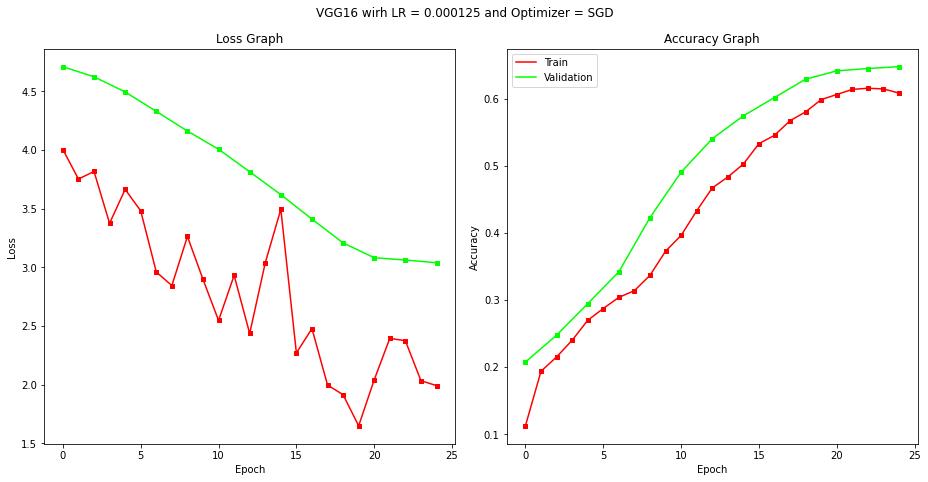

Min Loss: Train: 1.650199, Val: 3.038928
Max Accuracy: Train: 0.615837, Val: 0.647994

Best accuracy on Validation set 0.6479944674965422
*** Validation Accuracy: 0.6622882820601452 ***


In [15]:
from torchvision.models import vgg16
net = vgg16(pretrained=True)


#Print the number of Weights
#net = FreezeNetwork(net,1)

for child in net.children():
  for param in child.parameters():
    param.requires_grad = False
    
net.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 2024), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(2024, NUM_CLASSES),                   
                      nn.LogSoftmax(dim=1))

NumParamsToTrain(net)

criterion = nn.CrossEntropyLoss()

BATCH_SIZE = 256
factor = 8
BATCH_SIZE = int(BATCH_SIZE / factor)
LR = LR / factor

train_dataloader, val_dataloader, test_dataloader = PrepareDataLoaders()

parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

print()
meta_t = 'vgg'+str(LR)+'_'+'SGD'
test, valid, best_acc = Training(net,meta_t)

print()
meta = 'VGG16 wirh LR = {} and Optimizer = {}'.format(LR, 'SGD')
PlotAccuracyLoss(test,valid,meta=meta)


print()
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
print('Best accuracy on Validation set {}'.format(best_acc))
_ = Validation(best_net, test_dataloader)

RESNET18

ERROR INPUT!! Received freeze = -1 ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###
13,691,557 total parameters.
13,691,557 training parameters.
0 frozen parameters.
1.00 ratio training/total.

Starting epoch 1/30, LR = [0.0005]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.6903791427612305
Step 10, Loss 4.415317058563232
Step 20, Loss 4.054323673248291
*** Validation Accuracy: 0.18291839557399722 ***
Starting epoch 2/30, LR = [0.0005]
Step 30, Loss 3.700772523880005
Step 40, Loss 3.639256000518799
Starting epoch 3/30, LR = [0.0005]
Step 50, Loss 3.828646659851074
Step 60, Loss 3.2134811878204346
*** Validation Accuracy: 0.30048409405255877 ***
Starting epoch 4/30, LR = [0.0005]
Step 70, Loss 3.11383056640625
Step 80, Loss 2.9577934741973877
Starting epoch 5/30, LR = [0.0005]
Step 90, Loss 2.9885003566741943
Step 100, Loss 2.7354116439819336
*** Validation Accuracy: 0.394536652835408 ***
Starting epoch 6/30, LR = [0.0005]
Step 110, Loss 2.7400734424591064
Step 120, Loss 2.687650680541992
Step 130, Loss 2.812746524810791
Starting epoch 7/30, LR = [0.0005]
Step 140, Loss 2.649595022201538
Step 150, Loss 2.523369789123535
*** Validation Accuracy: 0.5044951590594744 ***
Starting epoch 8/30, LR = [0.0005]
Step 160, Loss 2.6521427631378174
Step 1

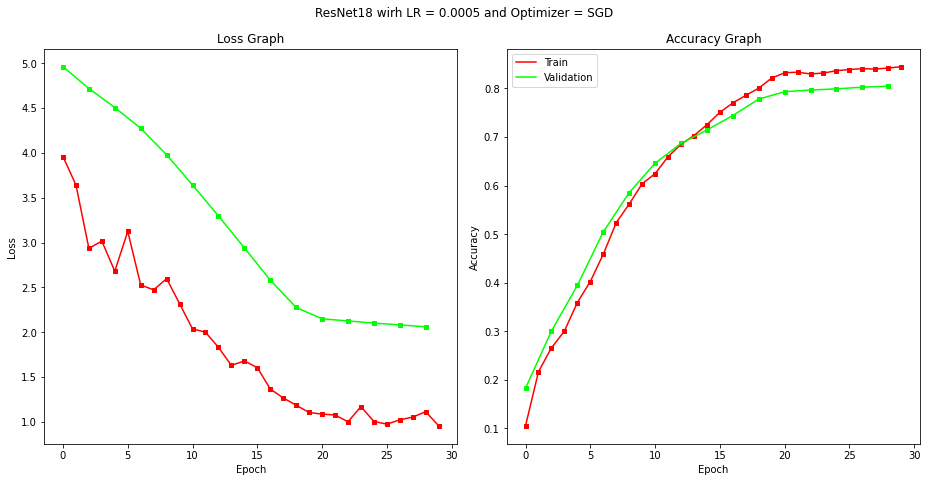

Min Loss: Train: 0.955315, Val: 2.060253
Max Accuracy: Train: 0.844744, Val: 0.804633

Best accuracy on Validation set 0.8046334716459198
*** Validation Accuracy: 0.811959903214656 ***


In [0]:
from torchvision.models import resnet18
from collections import OrderedDict

net = resnet18(pretrained=True)

#Add FC Layer
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,4096)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(4096,NUM_CLASSES)),
    ('output', nn.LogSoftmax(dim=1))
]))

net.fc = fc

#Print the number of Weights
net = FreezeNetwork(net,-1)

criterion = nn.CrossEntropyLoss()

BATCH_SIZE = 256

#Depending on which GPU Google Colab assign, you may need to reduce the batch size (factor of 2 is enough)
'''
factor = 2
BATCH_SIZE = int(BATCH_SIZE / factor)
LR = LR / factor
''' 

train_dataloader, val_dataloader, test_dataloader = PrepareDataLoaders()

parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


print()
meta_t = 'resn'+str(LR)+'_'+'SGD'
test, valid, best_acc = Training(net,meta_t)

print()
meta = 'ResNet18 wirh LR = {} and Optimizer = {}'.format(LR, 'SGD')
PlotAccuracyLoss(test,valid,meta=meta)


print()
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
print('Best accuracy on Validation set {}'.format(best_acc))
_ = Validation(best_net, test_dataloader)